# Handsign(수화) MNIST project

## 0. Purpose and Introduction of My Project

I have chosen the dataset of **'Sign Language'**, the language that is used by deaf people.  
Sign language is a language used among deaf people who have difficulty hearing.  
But many people cannot use sign language.  
I was looking for good datasets, and I had found the dataset of 'sign language'.  
I was interested in sign language since I was at highschool, and I thought this project will be a good opportunity for understanding sign language.

Usually, sign language consists of a gesture corresponding to a word.  
However, many sign language have movements together, and like other languages, there are many words, so it is difficult to analyze them all. 
(The capacity is so large that the analysis takes too much time.)  

In this project, I planned to analyze the hand gestures corresponding to the *alphabet*.  
However, 'J' and 'Z' include movement, so this model was conducted to distinguish 24 alphabets except for these two.  

The purpose of this machine learning model is to use it for programs that interpret sign language immediately in situations such as video conferencing such as zoom.

The dataset is from https://www.kaggle.com/datasets/datamunge/sign-language-mnist

## 1. Importing the dataset

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
from IPython.display import Image
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


train_ds = pd.read_csv('dataset/sign_mnist_train.csv')
test_ds = pd.read_csv('dataset/sign_mnist_test.csv')

df = pd.concat([train_ds, test_ds])

First, I had imported all the modules needed in this project.  
And then, I had imported the dataset that is in the same folder with this ipynb file.  
After importing the datas, I had concatenated each datas since the data was already distributed to train & test data.  
Once combined, the data will be distributed directly later.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34627 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 207.6 MB


We can see that there exists 7171 datas, and 784 features.  
This dataset is almost samely constructed with MNIST dataset.  

One data indicates one photo of sign language.  
Each photo has gray-scale 784 pixels, which is 28 x 28, same as MNIST data photo.

We can know that the dataset is consisted with 7171 datas and 784 features.

## 2. Preprocessing and checking for missing values

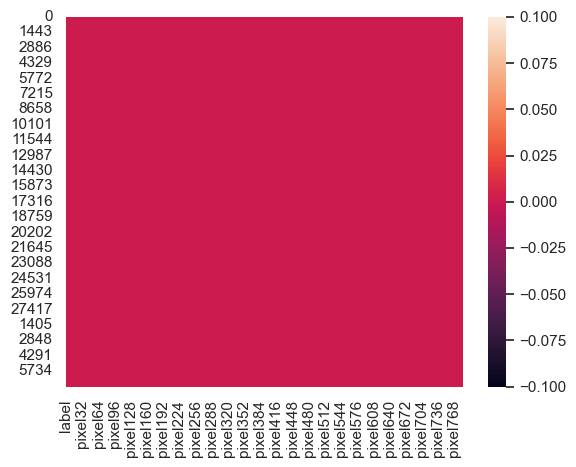

In [24]:
nullcheck = df.isnull()
sns.heatmap(nullcheck)
plt.show()

I had checked missing value first before preprocessing my dataset.  
`isnull()` function checks whether the value is *NULL*, and `sum()` function summarizes the number of null values of each columns.  

As the result above, we can find that there were no null values throughout the whole data.  
(The heatmap shows that all values of `nullcheck` is 0) 

In [25]:
X = (df.drop(columns='label').astype(np.float32)/255.0).to_numpy()
y = df['label'].astype(int).to_numpy()

used_alphabet = 'ABCDEFGHIKLMNOPQRSTUVWXY'
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

I had preprocessed the data as above.  
Since the data is black-and-white image data, like MNIST, each data value consists of an alpha value of black-and-white data. 

These values consist of values ranging from 0 to 255.  
Therefore, scaling may be performed to a value between 0 and 1 only by dividing by 255.

In addition, I had declared the used alphabet string(alphabet without 'J' and 'Z') to use it later.

## 3. EDA

Let's see some examples in this data.

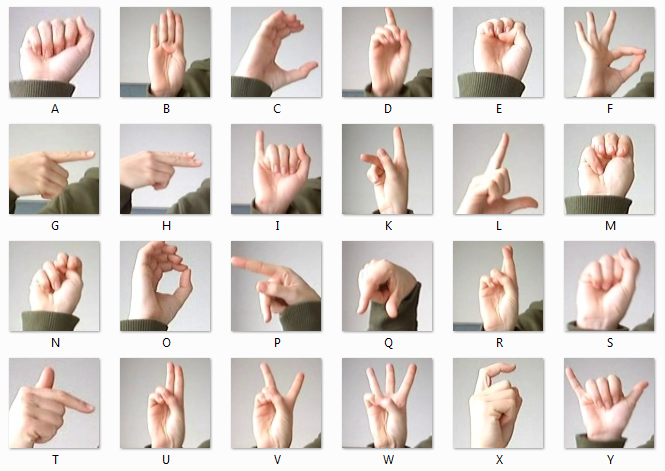

In [26]:
Image(filename='img/amer_sign.png', width = 900)

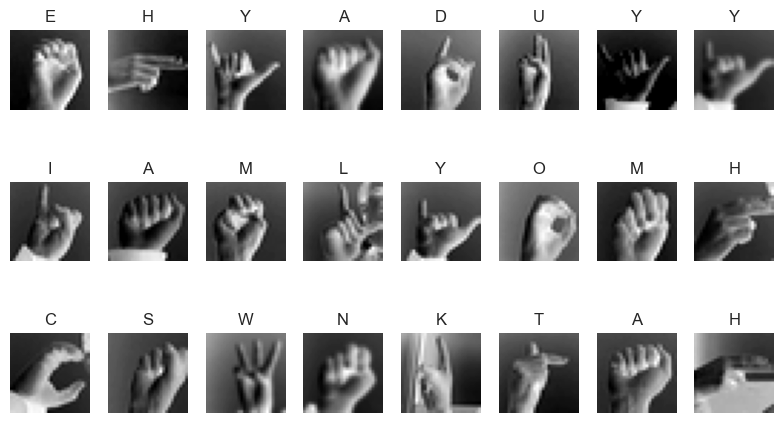

In [27]:
N = 3
M = 8
fig = plt.figure(figsize=(8, 5))

for i in range(N):
    for j in range(M):
        plt.subplot(N, M, i*M+j+1)
        idx = np.random.randint(len(y))
        a_digit = X[idx, :]
        a_digit_img = a_digit.reshape(28,28)

        plt.imshow(a_digit_img, cmap='binary')
        plt.axis('off')
        plt.title(f'{alphabet[y[idx]]}')

plt.tight_layout()
plt.show()

The first picture is a summary of the sign language actually used.  
The second picture is a random data drawn from the dataset and output with the label.

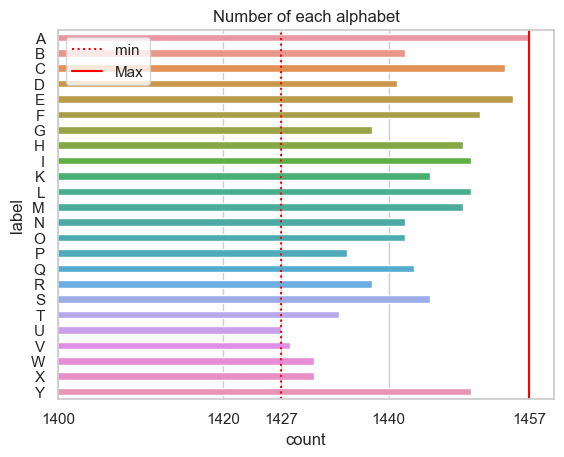

In [28]:
tmp = []
for i in used_alphabet:
    tmp.append(i)

cnt = df['label'].value_counts().sort_index(ascending=True)
min = cnt.min()
Max = cnt.max()

cnt = cnt.to_frame()
cnt.index = tmp
cnt.rename(columns = {'label': 'count'}, inplace=True)
cnt.insert(loc=0, column='label', value=tmp)

sns.set_theme(style='whitegrid')
sns.barplot(data=cnt, x='count', y='label', orient='h', width=[0.5])
plt.xlim(1400, 1460)
plt.axvline(x = min, color='red', linestyle=':', label='min')
plt.axvline(x = Max, color='red', linestyle='-', label='Max')

x_val = []
for i in range(1400,1460,20):
    x_val.append(i)
x_val.append(min)
x_val.append(Max)
plt.xticks(x_val)

plt.legend(loc='upper left')
plt.title('Number of each alphabet')

plt.show()

The graph above shows the number of each alphabets.
The fewest were U, 1427, and the most were A, 1457.

All number of alphabets had ranged from 1427 to 1457, we can know that the data is evenly distributed.

## 4. Dimension Reduction, feature selection, and/or feature engineering

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Before designing the model for ML, I had splitted the dataset into training data and testing data.  

I had chosen test size as 30% of the entire dataset.  
I had set `stratify` as `y` so that the dataset can be distributed evenly by the label.

Since each samples has 784 features, and this means each data has 784 dimension.  
This is a lot of dimensions, and this may increase the accuracy of the model, but it also gives burden to the model.  
So we should reduce the dimension.
However, reducing the dimension in arbitrary process may decrease the accuracy of the model.

This is why it is necessary to reduce the dimension in the direction of utilizing the characteristics of the original data as much as possible.  
We can use two ways of dimension reduction, PCA and LDA.

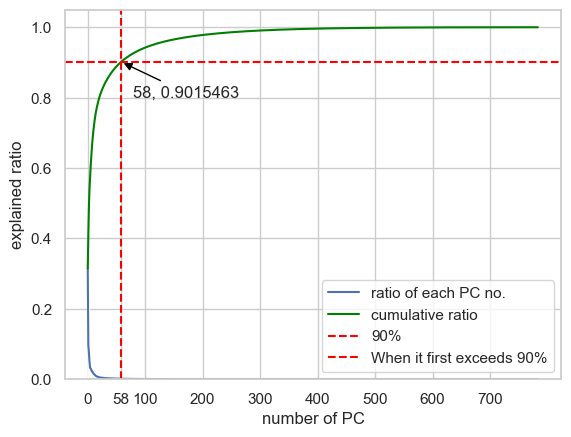

Least needed number of component that explains more than 90% of data is 58


In [30]:
pca = PCA(random_state=42)

pca_X_train = pca.fit_transform(X_train)

plt.plot(pca.explained_variance_ratio_, label = 'ratio of each PC no.')
plt.bar(x=range(1,785), height = pca.explained_variance_ratio_,)

cumul = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumul, color = 'green', label = 'cumulative ratio')

plt.axhline(y = 0.9, linestyle = '--', color = 'red', label = '90%')
n_comp = np.argmax(cumul >= 0.9) + 1
plt.axvline(x = n_comp, linestyle = '--', color='red', label = 'When it first exceeds 90%')

x_val = []
for i in range(0,784,100):
    x_val.append(i)
x_val.append(n_comp)
plt.xticks(x_val)

arrowprops = dict(color='black',arrowstyle="-|>")
plt.annotate(str(int(n_comp)) + ", " + str(cumul[n_comp]), xy = (n_comp, cumul[n_comp]), xytext = (n_comp + 20, cumul[n_comp]-0.1), arrowprops=arrowprops)
plt.legend()

plt.xlabel('number of PC')
plt.ylabel('explained ratio')

plt.show()

print(f'Least needed number of component that explains more than 90% of data is {n_comp}')


This code is for observeing the numbers of PC that is needed to explain the variability of the dataset.  
The blue line insists the ratio explained of data increased when one more PC is added.  
The green line instist the culmulative ratio.  

As we can see above, to explain more than 90% of the data, at least 58 PC were needed.

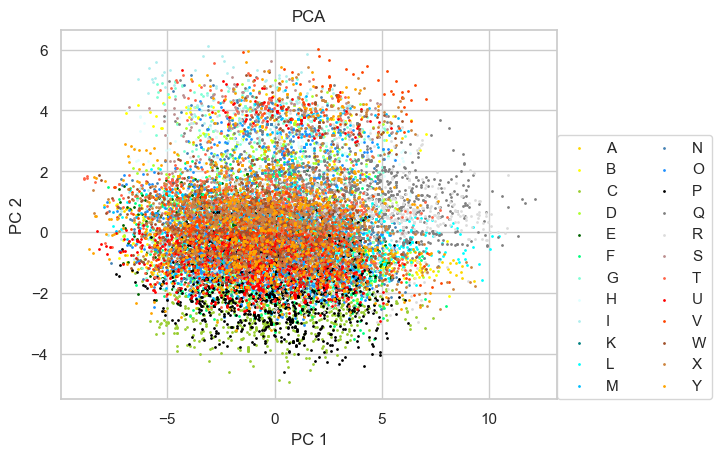

In [31]:
# import matplotlib
# cmap = matplotlib.colormaps['nipy_spectral']
# color = []

# for i in range(24):
#    color.append(np.random.rand(3,))

color = ['black', 'gray', 'gainsboro', 'rosybrown', 'tomato', 'red', 'orangered', 'sienna', 'peru', 'orange', 'gold', 'yellow', 'yellowgreen', 'greenyellow', 'darkgreen', 'springgreen', 'aquamarine', 'lightcyan', 'paleturquoise', 'teal', 'cyan', 'deepskyblue', 'steelblue', 'dodgerblue']
color = color[10:] + color[:10]

for g in range(0, 24):
    plt.scatter(pca_X_train[y_train==g, 0], pca_X_train[y_train==g, 1], color = color[g], label=used_alphabet[g], s=1)


plt.title('PCA')
plt.legend(loc=(1,0), ncol=2)

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

Using PC 1 and 2, the values corresponding to each alphabet were drawn using scatterplot on one graph as above.  
However, perhaps because there are too many classes, it is difficult to grasp at a glance.  

After observing the graph of PCA, I had used LDA to distribute it again.  
The process is as follows.

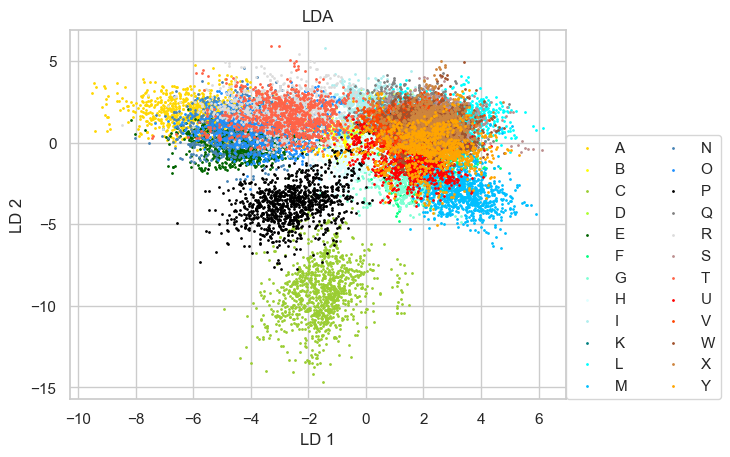

In [32]:
lda_ = LDA(n_components = 24 - 1)
lda_X_train = lda_.fit_transform(X_train, y_train)

for g in range(24):
    plt.scatter(lda_X_train[y_train==g, 0], lda_X_train[y_train==g, 1], color = color[g], label=used_alphabet[g], s=1)

plt.title('LDA')
plt.legend(loc = (1,0), ncol=2)

plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.show()

As a result of drawing using LDA, a picture that seemed to be classified more intuitively was drawn.

This is thought to be due to LDA's reduction in dimensions uses a strategy to minimize the variance within the class and maximize the variance between classes.

In [33]:
# make a region-decisioner referring to professor's document.

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    colors = color
    cmap = ListedColormap(colors)
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    plt.subplot(1,2,2)

    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1], alpha = 0.8, c=colors[idx], label=chr(65+c1), s=1)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


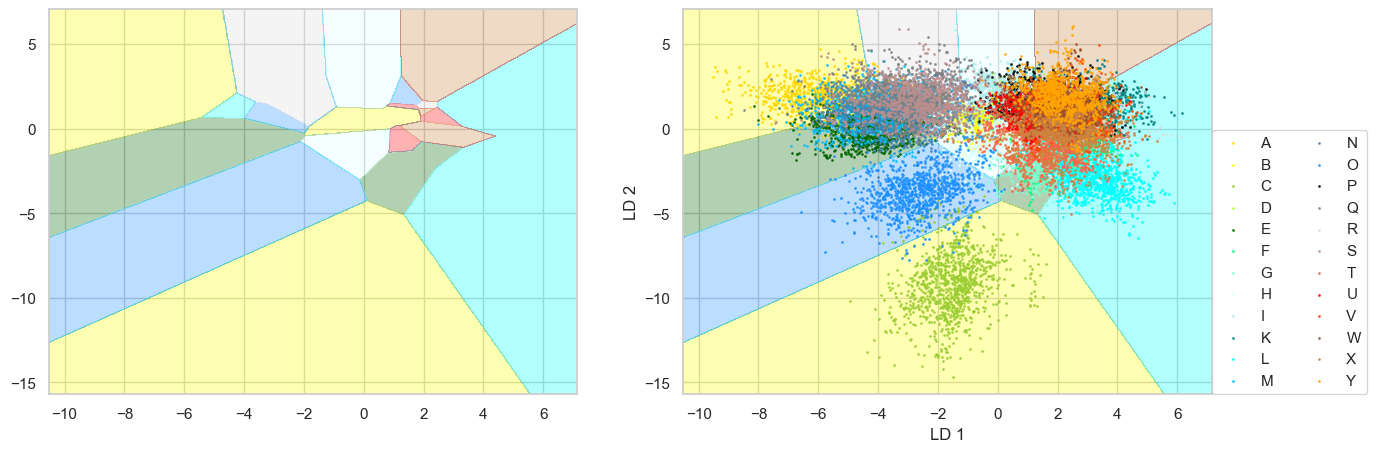

In [34]:
# draw the region of each classification that is discoverd via Logistic Regression (referred to professor's document)

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

lda = LDA(n_components = 3 - 1)
lda_ = lda.fit(X_train, y_train)
lda_X_train = lda_.transform(X_train)

lr_ = LogisticRegression()
lr_ = lr_.fit(lda_X_train, y_train)

plot_decision_regions(lda_X_train, y_train, classifier=lr_)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc=(1,0), ncol=2)

plt.show()

It is also possible to divide the area at a glance as described above.

Since the data doesn't use special or unrelated features, I thought feature selecting or feature engineering was not needed in this project.

In [35]:
pca = PCA(n_components=n_comp, random_state=42)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

lda = LDA(n_components = 24 - 1)
lda_ = lda.fit(X_train, y_train)
lda_X_train = lda_.transform(X_train)
lda_X_test = lda_.transform(X_test)

I had reduced the dimension as above.  
I've chosen the number of components used for PCA that explains more than 90% of the data, which we found it before.


## 5. Applying ML algorithms

First, the purpose of this project is to immediately translate sign language in video conferences such as Zoom, as I said earlier.

Therefore, I considered the release of this program in two cases.

First, a program that users can collect data directly, so it is a method of updating the prediction model when executing the program.  
In this case, there is a high risk that the accuracy of prediction will be reduced because the program user may upload malicious data or error data.

Second, it is the case that the program provider, that is, releases a program that has completed learning after the training.  
In this case, it is not necessary to consider the time to construct the model, since the time required for learning must be borne before release.

Despite the most important task in the model is to have a fast `prediction speed` in interpreting, we are not predicting a huge data at once.  
I thought the time difference between *fast-and-low-accuracy-predicting* model and *slow-and-high-accuarcy-predicting* model in small datas is negligible.  
We will interpret the alphabets one-by-one, so the time difference will be very small.

So I chose the second one. 
In short, it will be important to have high accuracy(to reduce mistranslation) without considering the time the model takes to learn and predict. Also, we have all labels of each sample.  
I thought English needs an accurate alphabet translation because one alphabet could change and become a completely different word. (such as glow-flow-blow, which only differs the first alphabet and has totally different meanings.)

So I will test the accuarcy of each models, SVC, LR, DT to choose the most accurate model.  
Since it takes a lot of time, I had attached the screenshot of the result.

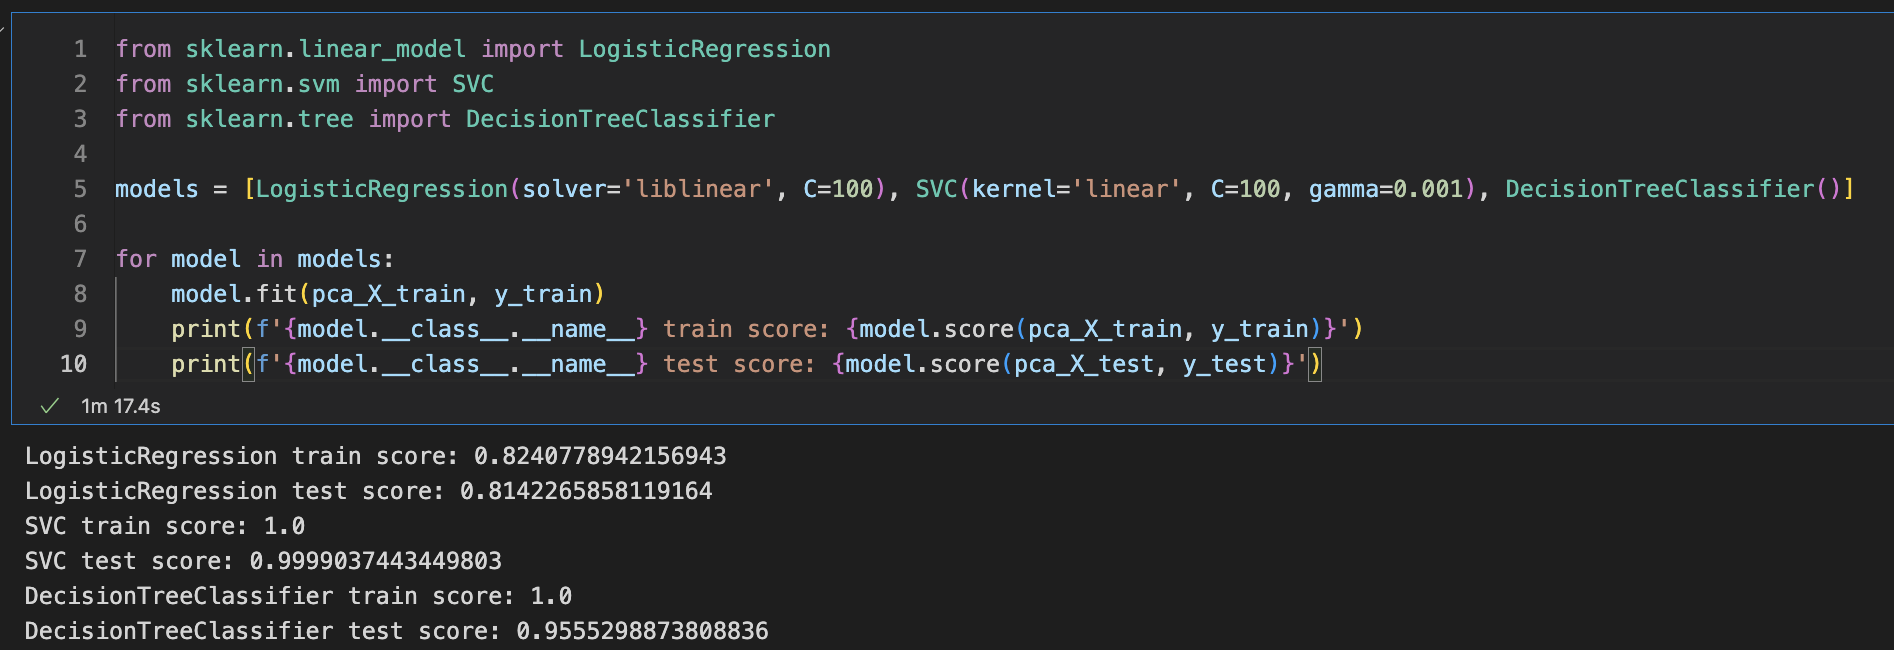

In [36]:
Image(filename='img/models_accuracy.png', width = 900)

Based on the results, I will use SVC that has high prediction accuracy even if the prediction speed is relatively slow.  

## 6. Model selection for the best ML model

Next, I will use `greed search` algorithm to find the most fitted hyperparameter.  
It also takes a long time to complete searching, I attached the screenshot.

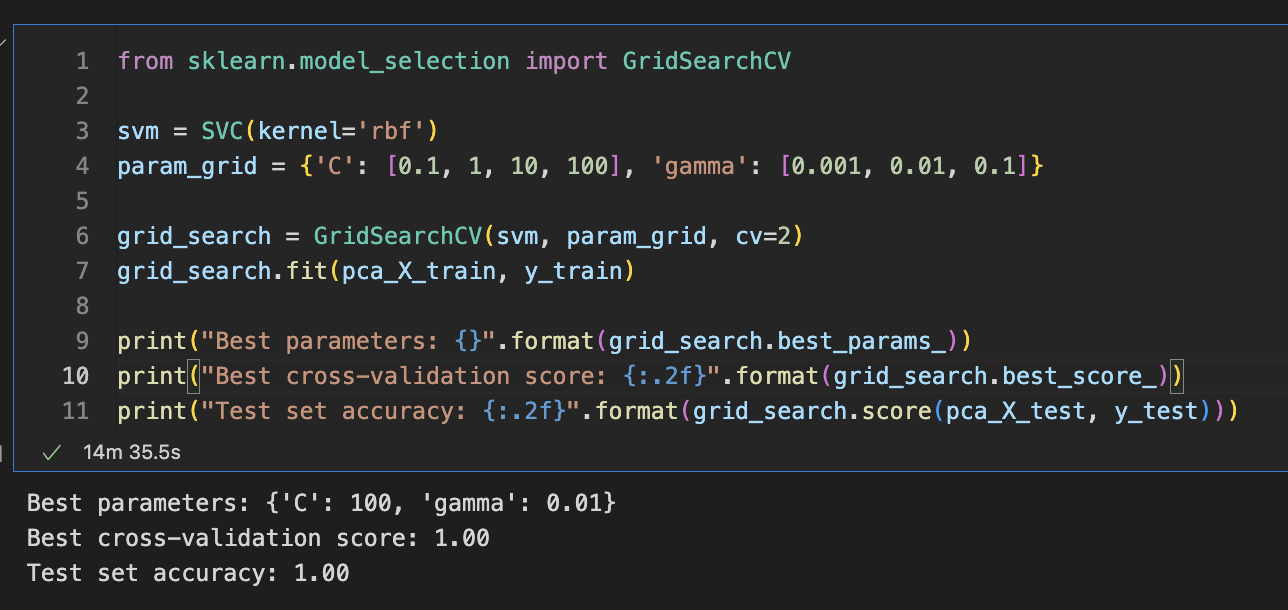

In [37]:
Image('img/hyperparameter_greed_search.png', width=600)

The values for the best results were 100 for C and 0.01 for gamma for PCA-dim reduced-data.  
Based on this value, the mensioned data was learned once through PCA and once through LDA.

In [38]:
svc_lda = SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
svc_lda.fit(lda_X_train, y_train)

# make prediction
predict = svc_lda.predict(lda_X_test) 
score = accuracy_score(predict, y_test)

# print the accuracy
print('The accuracy of this model(using LDA) is : {:.3f} %'.format(100 * score))

The accuracy of this model(using LDA) is : 99.856 %


In [39]:
svc_pca = SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
svc_pca.fit(pca_X_train, y_train)

predict = svc_pca.predict(pca_X_test)
score = accuracy_score(predict, y_test)

# print the accuracy
print('The accuracy of this model(using PCA) is : {:.3f} %'.format(100 * score))

The accuracy of this model(using PCA) is : 99.981 %


The accuarcy of each models were up to 99.85% and 99.98% each.  
We can think that the accuracy of this model is quite high.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

pca = PCA(n_components=n_comp)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

svc_PCA_ = SVC(kernel='rbf', C=100, gamma=0.01)
svc_PCA_.fit(pca_X_train, y_train)

predict = svc_PCA_.predict(pca_X_test)
score = accuracy_score(predict, y_test)

print('The accuracy of this model(using PCA) is : {:.3f} %'.format(100 * score))

The accuracy of this model(using PCA) is : 100.000 %


In addition, it was confirmed that the train/test set, which was completely randomly selected without the `random_state` value fixed, showed quite high accuracy.

## 7. Discussion

I took a picture and checked it to see if it could be applied in real life.  
I made my own name in sign language and took a photo of it.  
First, the dataset I took a picture of is scaled as follows, and then the prediction is made using LDA and PCA, respectively.

(The code to preprocess the photos I took is involved in the ZIP file.)

In [41]:
real_data = pd.read_csv('real_data.csv')
X_real = (real_data.drop(columns='label').astype(np.float32)/255.0).to_numpy()

lda_X_real = lda_.transform(X_real)
real_predict_pca = svc_lda.predict(lda_X_real)

pca_X_real = pca.transform(X_real)
real_predict_lda = svc_pca.predict(pca_X_real)

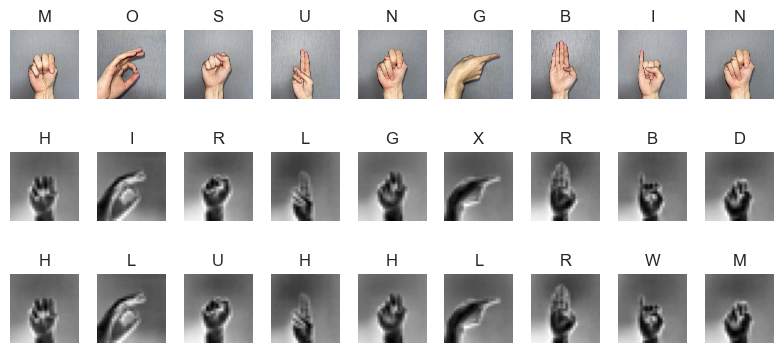

In [42]:
name = []
for i in 'MOSUNGBIN':
    name.append(i)

fig = plt.figure(figsize=(8, 4))
for i in range (0, 9):
    plt.subplot(3, 9, i+1)
    plt.imshow(img.imread('img/realworld/original_img/' + name[i] + '.png'))
    plt.axis('off')
    plt.title(name[i])

for i in range (0, 9):
    plt.subplot(3, 9, 10+i)
    plt.imshow(X_real[i, :].reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.title(chr(65+real_predict_pca[i]))

for i in range (0, 9):
    plt.subplot(3, 9, 19+i)
    plt.imshow(X_real[i, :].reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.title(chr(65+real_predict_lda[i]))

plt.tight_layout()
plt.show()

The results showed below-expected performance as above.  
In fact, there were no values that were correct. It definetely seems to need some development.
This is a result compared to the experimental data showing an accuracy of 99.9% or higher.

There are several reasons why this result occurred.

First, it will be greatly affected by light because it learns on a gray scale.  
Even with the same hand shape, the pixel value will vary greatly from the experimental data depending on the skin color, background color, and amount of ambient light, making it difficult.  
We can think that all the black colors in the background were recognized and affected the occurrence of errors.

Second, since the size of the image picture is not large enough, a mismatch between similar hand movements may occur.  
However, if the resolution of the picture is increased to solve this problem, the time required for prediction should be increased, and the same method as DT, not SVC, should be considered.  

Third, just as there is a dialect in each region, the method of sign language varies slightly from person to person, so it can be interpreted as a different value depending on the shape shown on the camera.  
In the case of photos I took myself, there are relatively more black because there are more margins(area of background) than the data actually used in the training.  
It is highly likely that this information has adversely affected the prediction.  

Based on these results and feedback, we will be able to create a better machine learning model.